In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
# Bank BRI dengan kode BBRI akan menjadi emiten yang akan kita analisis

emiten = pd.read_csv('/content/drive/MyDrive/DS PM/bbri.csv')
ihsg = pd.read_csv('/content/drive/MyDrive/DS PM/ihsg.csv')

library Explaination:

Emiten: a company that been listed in stock market.

IHSG: Weight index of all companies that been listed in Indonesia stock exchange market

OCHL: Open, Close, High, and Low Price within a day.

# Data Preparation

In [24]:
# Check null data
print(ihsg.isna().sum().sum())
print(emiten.isna().sum().sum())

312
6


Kolom Open, High, Low, Adj Close pada ihsg & emiten kita drop karena karena kita hanya membutuhkan Close Price & Volume.

In [25]:
def drop_col(emiten):
  return emiten.drop(['Open', 'High', 'Low', 'Adj Close'], axis = 1)

ihsg = drop_col(ihsg)
emiten = drop_col(emiten)

In [26]:
print(emiten.shape)
print(ihsg.shape)

(2374, 3)
(2374, 3)


In [27]:
# merge ihsg to emiten because ihsg is one of our feature
def merge_emiten(emiten):
  return pd.merge(emiten, ihsg, how='left', on='Date')

emiten = merge_emiten(emiten)

In [28]:
def rename(emiten):
  emiten.rename(columns = {'Close_x':'Close', 'Volume_x':'Volume', 'Close_y':'Close_ihsg', 'Volume_y':'Volume_ihsg'}, inplace = True)

rename(emiten)

In [29]:
def dtime(dtime_emiten):
  dtime_emiten['Date'] = pd.to_datetime(dtime_emiten['Date'])
  return dtime_emiten.set_index('Date')

emiten = dtime(emiten)

kita akan mencoba memprediksi harga besok dengan menggunkan fitur pada hari h, jadi kita buat variabel Y dengan harga esoknya.

In [30]:
# create y from tommorow price
emiten['Close+1'] = emiten['Close'].shift(-1)

**Imputation**

pasar saham pada hari sabtu, minggu dan tanggal merah libur, sehingga tanggal pada data terisi atau kosong, jadi harus didrop dan tidak bisa diimputasi

In [31]:
def dropna(emiten):
  emiten.dropna(inplace=True)

dropna(emiten)

In [36]:
print(emiten.shape)
emiten.describe()

(2295, 5)


,Close,Volume,Close_ihsg,Volume_ihsg,Close+1
count,2295.000000,2.295000e+03,2295.000000,2.295000e+03,2295.000000
mean,2745.174818,1.444807e+08,5307.758403,9.249068e+07,2746.264142
std,979.819264,8.962525e+07,734.412216,3.727418e+08,979.567375
min,1050.000000,1.500000e+01,3654.582031,7.027200e+06,1050.000000
25%,2010.000000,8.767770e+07,4709.702637,3.673945e+07,2015.000000
50%,2445.000000,1.211755e+08,5245.956055,5.183420e+07,2445.000000
75%,3610.000000,1.727275e+08,5999.488038,8.625115e+07,3620.000000
max,4890.000000,8.726073e+08,6689.287109,9.788202e+09,4890.000000


Terdapat beberapa nilai zero (0), pada Volume. Kemungkinan hal ini ada dua, antara tidak ada datanya/tidak terinput, atau emiten saat itu terkena Suspend dari BEI, sehingga pilihan yang tepat adalah di-remove.

In [33]:
# Remove row value
def remove_val(removed_row):
  emiten.drop(emiten.loc[removed_row==0].index, inplace=True)

remove_val(emiten['Volume_ihsg'])
remove_val(emiten['Volume'])

# Data Split

kita akan menggunakan 60:20:20 split untuk data train, validation, dan test.

In [34]:
df_train = emiten[:int(emiten.shape[0]*0.6)]
df_test = emiten[int(emiten.shape[0]*0.6):]
df_val = df_test[int(df_test.shape[0]*0.5):]
df_test = df_test[:int(df_test.shape[0]*0.5)]

In [35]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(1377, 5)
(459, 5)
(459, 5)


In [37]:
emiten

,Close,Volume,Close_ihsg,Volume_ihsg,Close+1
Date,,,,,
2012-03-16,1360.0,96527500.0,4028.537109,33788800.0,1360.0
2012-03-19,1360.0,72900000.0,4024.732910,23992000.0,1340.0
2012-03-20,1340.0,155732500.0,4022.167969,24426300.0,1350.0
2012-03-21,1350.0,84340000.0,4036.233887,27568100.0,1360.0
2012-03-22,1360.0,146550000.0,4041.559082,23195800.0,1350.0
...,...,...,...,...,...
2021-09-29,3740.0,143081800.0,6162.554199,230726900.0,3850.0
2021-09-30,3850.0,416099000.0,6286.942871,202745700.0,3900.0
2021-10-01,3900.0,359864700.0,6228.845215,190252600.0,3970.0


In [38]:
# Label for x and y variable
X_col = ['Close','Volume','Close_ihsg','Volume_ihsg']
y_col = ['Close+1']

# Create train, validation, test data
X_train = df_train[X_col]
y_train = df_train[y_col]
X_test = df_test[X_col]
y_test = df_test[y_col]
X_val = df_val[X_col]
y_val = df_val[y_col]

# Feature Engineering

feature engineering yang kita lakukan sebagian besar berasal dari harga penutupan saja, yaitu kita buat Simple Moving Average (SMA), Exponential Moving Average (EMA), selisih Close Price dengan SMA, rata-rata Close & Open Price, dan Simple Moving Average dari volume.

**feature on train data**

In [39]:
# CREATE MOVING AVERAGE
X_train['SMA_5'] = X_train.Close.rolling(5, min_periods=1).mean()
X_train['SMA_20'] = X_train.Close.rolling(20, min_periods=1).mean()
X_train['SMA_60'] = X_train.Close.rolling(60, min_periods=1).mean()
X_train['SMA_120'] = X_train.Close.rolling(120, min_periods=1).mean()

# Exponential Moving Average
X_train['EMA_0.1'] = X_train.Close.ewm(alpha=0.1, adjust=False).mean()
X_train['EMA_0.3'] = X_train.Close.ewm(alpha=0.3, adjust=False).mean()

# The dsitance betwen SMA and close price
X_train['distance_SMA_5'] = X_train['Close'] - X_train['SMA_5']
X_train['distance_SMA_20'] = X_train['Close'] - X_train['SMA_20']
X_train['distance_SMA_60'] = X_train['Close'] - X_train['SMA_60']
X_train['distance_SMA_120'] = X_train['Close'] - X_train['SMA_120']

**feature on val data**

In [40]:
# CREATE MOVING AVERAGE
X_val['SMA_5'] = X_val.Close.rolling(5, min_periods=1).mean()
X_val['SMA_20'] = X_val.Close.rolling(20, min_periods=1).mean()
X_val['SMA_60'] = X_val.Close.rolling(60, min_periods=1).mean()
X_val['SMA_120'] = X_val.Close.rolling(120, min_periods=1).mean()

# Exponential Moving Average
X_val['EMA_0.1'] = X_val.Close.ewm(alpha=0.1, adjust=False).mean()
X_val['EMA_0.3'] = X_val.Close.ewm(alpha=0.3, adjust=False).mean()

# The dsitance betwen SMA and close price
X_val['distance_SMA_5'] = X_val['Close'] - X_val['SMA_5']
X_val['distance_SMA_20'] = X_val['Close'] - X_val['SMA_20']
X_val['distance_SMA_60'] = X_val['Close'] - X_val['SMA_60']
X_val['distance_SMA_120'] = X_val['Close'] - X_val['SMA_120']

**feature on test data**

In [41]:
# CREATE MOVING AVERAGE
X_test['SMA_5'] = X_test.Close.rolling(5, min_periods=1).mean()
X_test['SMA_20'] = X_test.Close.rolling(20, min_periods=1).mean()
X_test['SMA_60'] = X_test.Close.rolling(60, min_periods=1).mean()
X_test['SMA_120'] = X_test.Close.rolling(120, min_periods=1).mean()

# Exponential Moving Average
X_test['EMA_0.1'] = X_test.Close.ewm(alpha=0.1, adjust=False).mean()
X_test['EMA_0.3'] = X_test.Close.ewm(alpha=0.3, adjust=False).mean()

# The dsitance betwen SMA and close price
X_test['distance_SMA_5'] = X_test['Close'] - X_test['SMA_5']
X_test['distance_SMA_20'] = X_test['Close'] - X_test['SMA_20']
X_test['distance_SMA_60'] = X_test['Close'] - X_test['SMA_60']
X_test['distance_SMA_120'] = X_test['Close'] - X_test['SMA_120']

# EXPLORATORY DATA ANALYSIS


Guna plot ini adalah untuk melihat trend harga antara BBRI dan IHSG, dimana memiliki korelasi yang cukup tinggi. Hal ini wajar untuk emiten BRI karena bobot BRI dalam IHSG diantara yang paling tinggi.

Text(0, 0.5, 'Price')

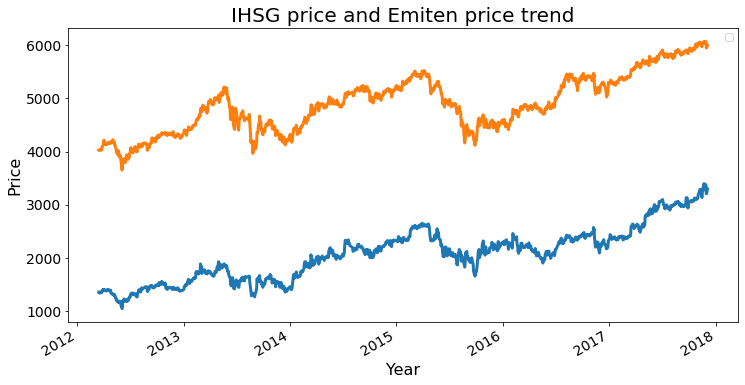

In [ ]:
# line plot
X_train[['Close','Close_ihsg']].plot(linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend('')

# title and labels
plt.title('IHSG price and Emiten price trend', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Price', fontsize=16)

Simple Moving Average (SMA) merupakan salah satu indikator yang dipakai banyak investor. Untuk pertimbangan pemilihan banyaknya hari yang diambil adalah untuk menangkap trand dalam, seminggu (5), sebulan (20), per Quarter (90), dan semester (120).

Text(0, 0.5, 'Price')

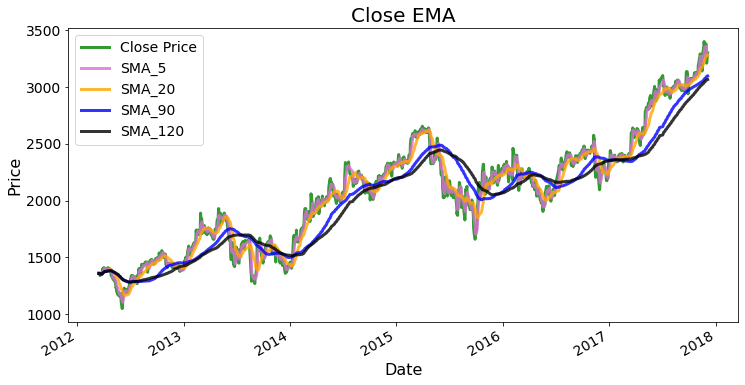

In [ ]:
# colors for the line plot
colors = ['green', 'orchid', 'orange', 'blue', 'black']

# line plot - the yearly average air temperature in Barcelona
X_train[['Close', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_120']].plot(color=colors, linewidth=3, figsize=(12,6), alpha=0.8)

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=['Close Price', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_120'], fontsize=14)

# title and labels
plt.title('Close EMA', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)

Salah satu bentuk dari Moving Average namun berkat penambahan weight nya membuat di lebih fit dalam menangkap harga. selain itu, pada pasar saham, selalu diasumsikan kenaikan harga, jadi EMA ini dirasa lebih pas.

Text(0, 0.5, 'Price')

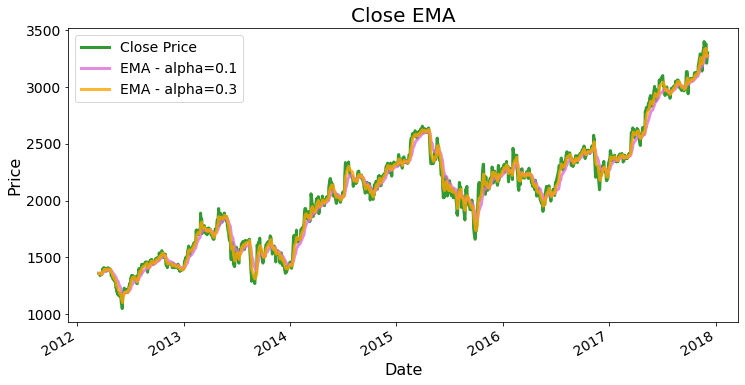

In [ ]:
# colors for the line plot
colors = ['green', 'orchid', 'orange']

# line plot - the yearly average air temperature in Barcelona
X_train[['Close', 'EMA_0.1', 'EMA_0.3']].plot(color=colors, linewidth=3, figsize=(12,6), alpha=0.8)

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=['Close Price', 'EMA - alpha=0.1', 'EMA - alpha=0.3'], fontsize=14)

# title and labels
plt.title('Close EMA', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)

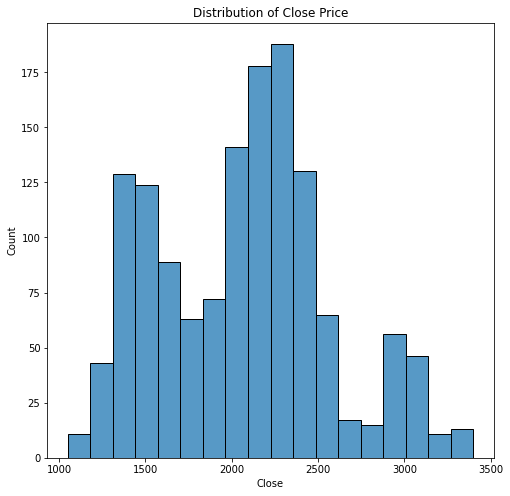

In [ ]:
plt.figure(figsize = (8,8))
p = sns.histplot(
    x = 'Close',
    data = X_train
)
plt.title('Distribution of Close Price')
plt.show()

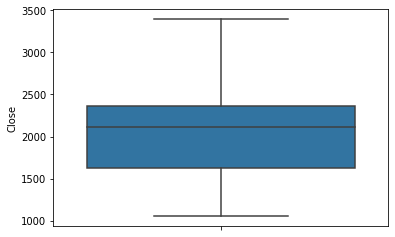

In [ ]:
sns.boxplot(y=X_train['Close'])
plt.show()

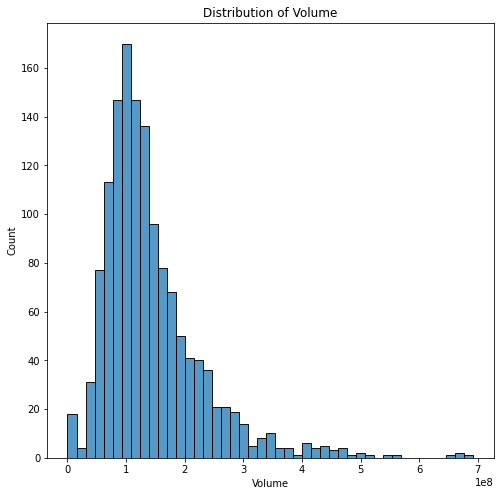

In [ ]:
plt.figure(figsize = (8,8))
p = sns.histplot(
    x = 'Volume',
    data = X_train
)
plt.title('Distribution of Volume')
plt.show()

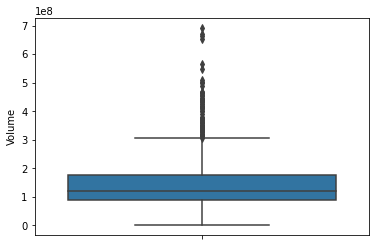

In [ ]:
sns.boxplot(y=X_train['Volume'])
plt.show()

Correlation Heat map dengan Pearson's Correlation kurang dari 40% feature yang berkolerasi.

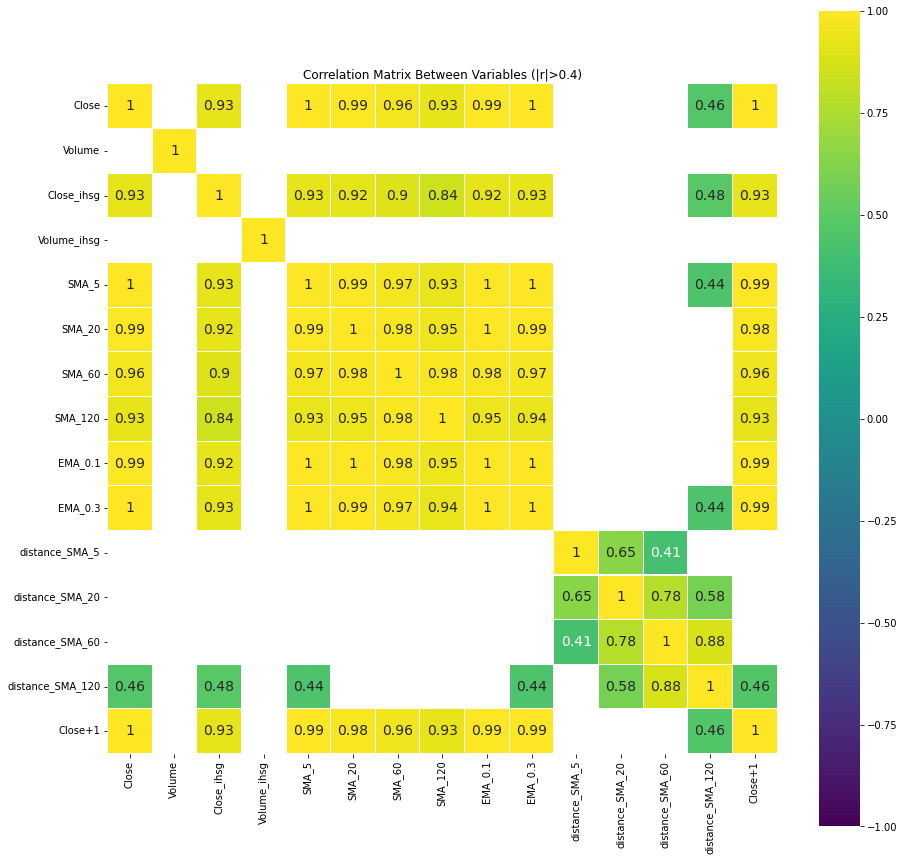

In [42]:
# Heat
train = pd.merge(X_train, y_train, how='left', on='Date')
corr2 = train.corr(method = 'pearson')
plt.figure(figsize=(15, 15))
sns.heatmap(corr2[(corr2 >= 0.4) | (corr2 <= -0.4)], cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,annot=True, annot_kws={"size": 14}, square=True)
plt.title('Correlation Matrix Between Variables (|r|>0.4)')
plt.show()  

# Machine Learning Model

Feature Selection

In [102]:
X_col_final = ['SMA_5', 'SMA_20', 'SMA_60', 'SMA_120']

X_train_final = X_train.drop(X_col_final, axis=1)
X_val_final = X_val.drop(X_col_final, axis=1)
X_test_final = X_test.drop(X_col_final, axis=1)

Model Selection

In [43]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=5,
    max_train_size=None,
)

In [147]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

models = []
models.append(('RFR', RandomForestRegressor()))
models.append(('KNR', KNeighborsRegressor()))
models.append(('DCR', DecisionTreeRegressor()))
models.append(('LR', LinearRegression()))
models.append(('RDG', Ridge()))
models.append(('XGB', XGBRegressor()))

# evaluate each model in turn
results = []
names = []
scoring = 'neg_mean_absolute_error'
for name, model in models:
    #kfold = model_selection.KFold(n_splits=5, shuffle=False)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=ts_cv, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

RFR: -152.765721 (110.705677)
KNR: -459.107424 (163.067261)
DCR: -154.768559 (82.846433)
LR: -31.384693 (3.906080)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.41607e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.01891e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.22302e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.18517e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-condit

RDG: -31.384593 (3.906060)
[06:37:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:37:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:37:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:37:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:37:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB: -153.701230 (118.209597)


**Training MOdel**

In [143]:
# define model
model = Ridge()

space = dict()
space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
space['alpha'] = [0.1, 0.25, 0.5, 0.75]
space['fit_intercept'] = [True, False]
space['normalize'] = [True, False]

# define search
search = RandomizedSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=-1, cv=ts_cv)

# execute search
result = search.fit(X_train, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -31.280562624189134
Best Hyperparameters: {'solver': 'svd', 'normalize': False, 'fit_intercept': False, 'alpha': 0.75}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


In [ ]:
# define search params
#params = {'n_estimators' : [5,20,50,100],
#          'max_features' : ['auto', 'sqrt'],
#          'max_depth' : [int(x) for x in np.linspace(10, 120, num = 12)],
#          'min_samples_split' : [2, 6, 10],
#          'min_samples_leaf' : [1, 3, 4],
#          'bootstrap' : [True, False]}

#params = {
    # Parameters that we are going to tune.
#    'max_depth':[2,3,6],
#    'min_child_weight': [1,2,5],
#    'eta':[.1,.3,.5],
#    'subsample': [1],
#    'colsample_bytree': [1]}


**Evaluation**

In [125]:
# Import Score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Function y_pred
def get_y_pred(data_x):
  y_pred = search.predict(data_x)
  return y_pred

# Funtion to print score
def get_score(data_x, data_y):
  y_pred_data = search.predict(data_x)
  print(mean_absolute_error(data_y, y_pred_data))
  print(r2_score(data_y, y_pred_data))

In [139]:
def get_visual(data_x, data_y):  
  #get score
  get_score(data_x, data_y)

  # merge data for plotting
  df_eval_train = pd.DataFrame({'Actual': data_y.to_numpy().flatten(), 'Predicted': get_y_pred(data_x).flatten()})

  # colors for the line plot
  colors = ['green', 'orchid']

  # line plot - the yearly average air temperature in Barcelona
  df_eval_train[['Actual', 'Predicted']].plot(color=colors, linewidth=3, figsize=(12,6), alpha=0.8)

  # modify ticks size
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.legend(labels=['Actual', 'Predicted'], fontsize=14)

  # title and labels
  plt.title('Plot Data Train', fontsize=20)
  plt.xlabel('Date', fontsize=16)
  plt.ylabel('Price', fontsize=16)

Test result on data training

27.297396491757095
0.9940283950516614


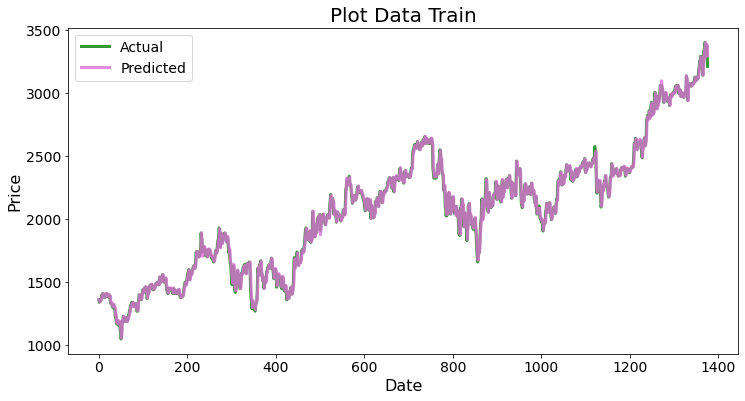

In [144]:
get_visual(X_train, y_train)

On Data Validation

70.97897800523091
0.9758467369915702


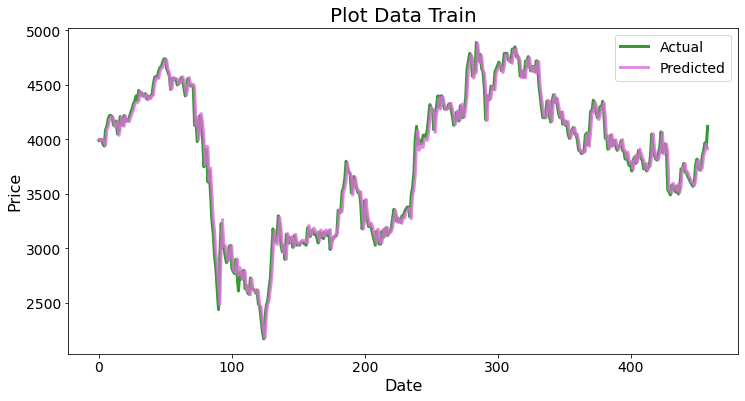

In [145]:
get_visual(X_val, y_val)

Result from data test

46.60248670341378
0.9822532960220661


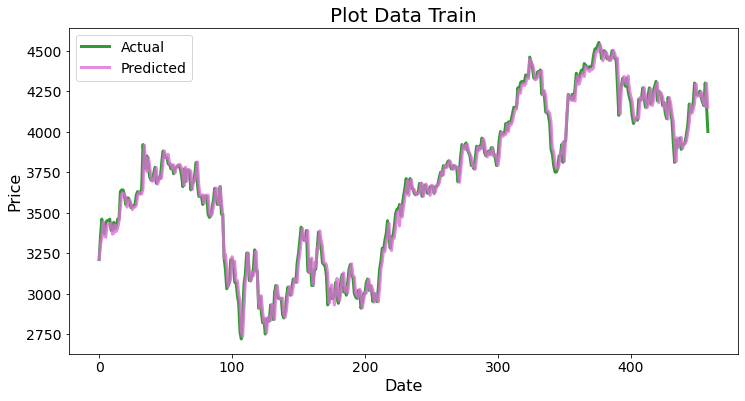

In [146]:
get_visual(X_test, y_test)